In [1]:
!nvidia-smi

Mon Jul 17 11:53:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   23C    P8    31W / 260W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     On   | 00000000:1C:00.0 Off |                  Off |
| 66%   

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

from GradCAM import *
from define_model import *
from load_label import *
from utilities import *
from Parse_TFrecords import *
import gc
import tensorflow as tf
import json
import glob
import matplotlib.image as mpimg


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from sklearn.metrics import classification_report, average_precision_score

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
print(gpus)
 
print(tf.__version__)

[]
2.8.0


In [3]:
checkpoint_filepath = 'checkpoints/checkpoints_mimic/checkpoint_BCE_Xception'


model = define_model('Xception')
model.load_weights(checkpoint_filepath)

# For GradCam

# First, we create a model that maps the input image to the activations
# of the last conv layer
last_conv_layer = model.get_layer(model.layers[-3].name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in model.layers[-2:]:
    x = model.get_layer(layer_name.name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [4]:
BATCH_SIZE = 32
dataset = 'mimic'

record_file_test = 'tfrecords/copd_{a}_test.tfrecords'.format(a=dataset)
test_dataset = (tf.data.TFRecordDataset(
    record_file_test, buffer_size=BATCH_SIZE, compression_type=None, num_parallel_reads=32)
.map(parse_TFrecord_train))

In [5]:
heat_map = []
heat_map_pp = []
preds = []
ids = []

for idx, (i, l) in enumerate(test_dataset):
    
    if (l.numpy() != 1):
        continue

    img_array = np.reshape(i, (1, 256, 256, 3))
    pred = model.predict(img_array)
    
    if (pred[0][0] >= 0.9):
        heat_map.append(show_heatmap(img_array, last_conv_layer_model, classifier_model))
        heat_map_pp.append(grad_cam_plus(img_array, last_conv_layer_model, classifier_model))
        preds.append(pred)
        ids.append(idx)
    else:
        continue
                        
preds = np.array(preds).reshape(len(preds,))
ids = np.array(ids).reshape(len(ids,))
order = np.argsort(np.array(preds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99201226


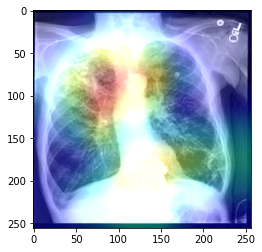

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99385476


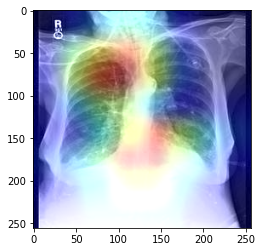

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99590266


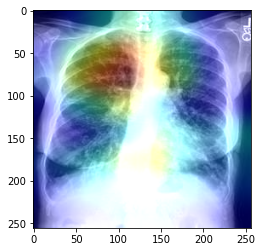

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9964291


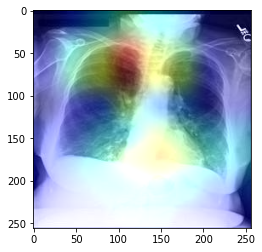

In [6]:
for i in order[-4:]:
    print(preds[i])
    plt.imshow(np.reshape(heat_map[i], (256, 256, 3)))
    fname = 'imgs/mimic_test/{a}_{b}_gradcam.jpg'.format(a=ids[i], b=preds[i])
    plt.savefig(fname)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


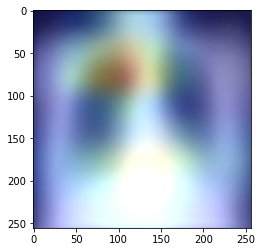

In [7]:
mean_heatmap = np.mean(heat_map, axis=0)
plt.imshow(np.reshape(mean_heatmap, (256, 256, 3)))
fname = 'imgs/mimic_test/mean_gradcam.jpg'
plt.savefig(fname)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99201226


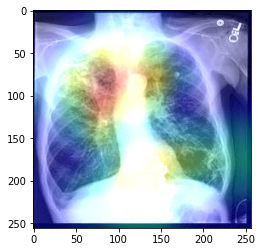

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99385476


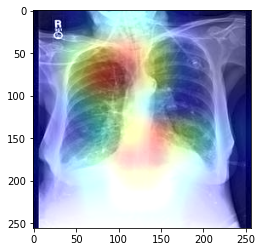

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99590266


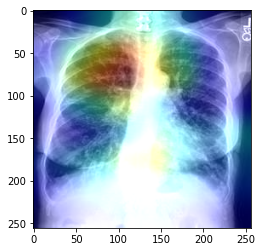

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9964291


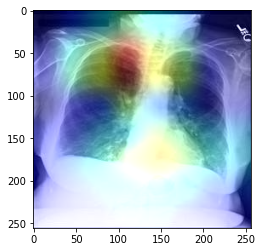

In [8]:
for i in order[-4:]:
    print(preds[i])
    plt.imshow(np.reshape(heat_map_pp[i], (256, 256, 3)))
    fname = 'imgs/mimic_test/{a}_{b}_gradcampp.jpg'.format(a=ids[i], b=preds[i])
    plt.savefig(fname)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


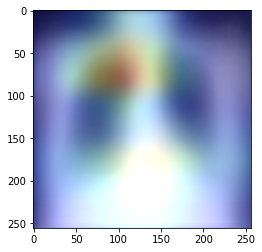

In [9]:
mean_heatmap = np.mean(heat_map_pp, axis=0)
plt.imshow(np.reshape(mean_heatmap, (256, 256, 3)))
fname = 'imgs/mimic_test/mean_gradcampp.jpg'
plt.savefig(fname)
plt.show()

In [10]:
BATCH_SIZE = 32
dataset = 'emory'

record_file_test = 'tfrecords/copd_{a}_test.tfrecords'.format(a=dataset)
test_dataset = (tf.data.TFRecordDataset(
    record_file_test, buffer_size=BATCH_SIZE, compression_type=None, num_parallel_reads=32)
.map(parse_TFrecord_train))

In [11]:
heat_map = []
heat_map_pp = []
preds = []
ids = []

for idx, (i, l) in enumerate(test_dataset):
    
    if (l.numpy() != 1):
        continue

    img_array = np.reshape(i, (1, 256, 256, 3))
    pred = model.predict(img_array)
    
    if (pred[0][0] >= 0.9):
        heat_map.append(show_heatmap(img_array, last_conv_layer_model, classifier_model))
        heat_map_pp.append(grad_cam_plus(img_array, last_conv_layer_model, classifier_model))
        preds.append(pred)
        ids.append(idx)
    else:
        continue
                        
preds = np.array(preds).reshape(len(preds,))
ids = np.array(ids).reshape(len(ids,))
order = np.argsort(np.array(preds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98944366


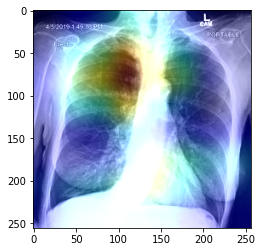

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98960394


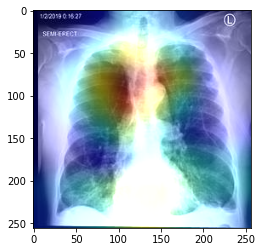

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9900986


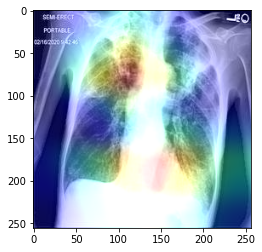

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9919981


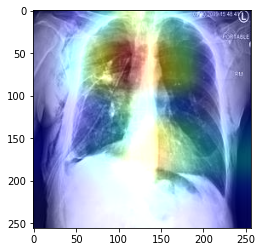

In [12]:
for i in order[-4:]:
    print(preds[i])
    plt.imshow(np.reshape(heat_map[i], (256, 256, 3)))
    fname = 'imgs/emory_test/{a}_{b}_gradcam.jpg'.format(a=ids[i], b=preds[i])
    plt.savefig(fname)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


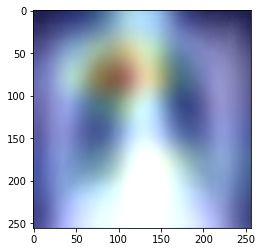

In [13]:
mean_heatmap = np.mean(heat_map, axis=0)
plt.imshow(np.reshape(mean_heatmap, (256, 256, 3)))
fname = 'imgs/emory_test/mean_gradcam.jpg'
plt.savefig(fname)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98944366


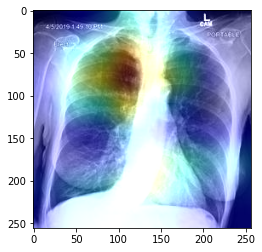

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98960394


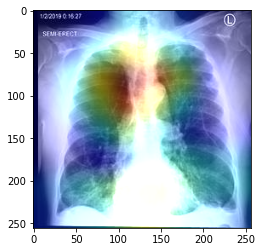

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9900986


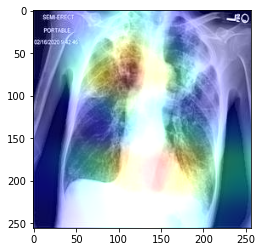

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9919981


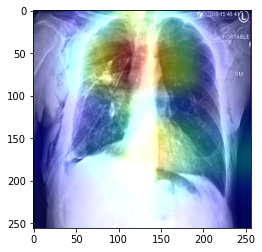

In [14]:
for i in order[-4:]:
    print(preds[i])
    plt.imshow(np.reshape(heat_map_pp[i], (256, 256, 3)))
    fname = 'imgs/emory_test/{a}_{b}_gradcampp.jpg'.format(a=ids[i], b=preds[i])
    plt.savefig(fname)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


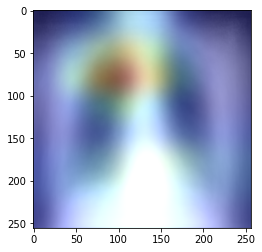

In [15]:
mean_heatmap = np.mean(heat_map_pp, axis=0)
plt.imshow(np.reshape(mean_heatmap, (256, 256, 3)))
fname = 'imgs/emory_test/mean_gradcampp.jpg'
plt.savefig(fname)
plt.show()

# Mann-Whitney test

In [80]:
archis = ['DenseNet121', 'DenseNet201', 'ResNet50V2', 'ResNet152V2', 'Xception', 'InceptionV3', 'InceptionResNetV2', 'MobileNetV2']
data = 'mimic'
split = 'test'

df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()
    
y_label = get_data_label('mimic', split)

In [84]:
label_0 = np.where(y_label==0)[0]
label_1 = np.where(y_label==1)[0]

df_0 = df.iloc[label_0]
df_1 = df.iloc[label_1]

<AxesSubplot:title={'center':'Mann–Whitney U test'}>

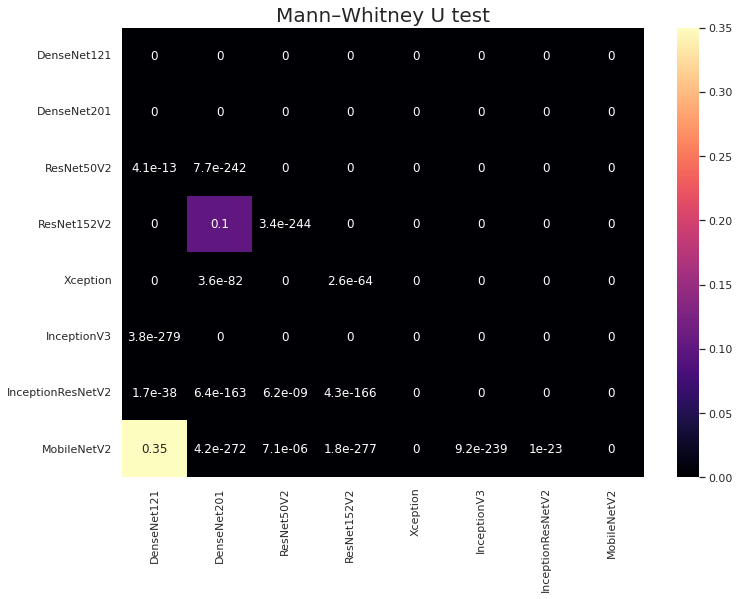

In [139]:
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

mat = [[0 for _ in range (len(archis))] for _ in range(len(archis))]

for i in range(len(archis)):
    for j in range(i+1, len(archis)):
        u1, p = mannwhitneyu(df[archis[j]], df[archis[i]])
        mat[j][i] = p

sns.set(rc={'figure.figsize':(11.7,8.27)})

# plt.matshow(np.array(mat))
plt.title('Mann–Whitney U test', fontsize = 20)
sns.heatmap(np.array(mat), annot=True, xticklabels=archis, yticklabels=archis, cmap='magma')

<AxesSubplot:title={'center':'T-test'}>

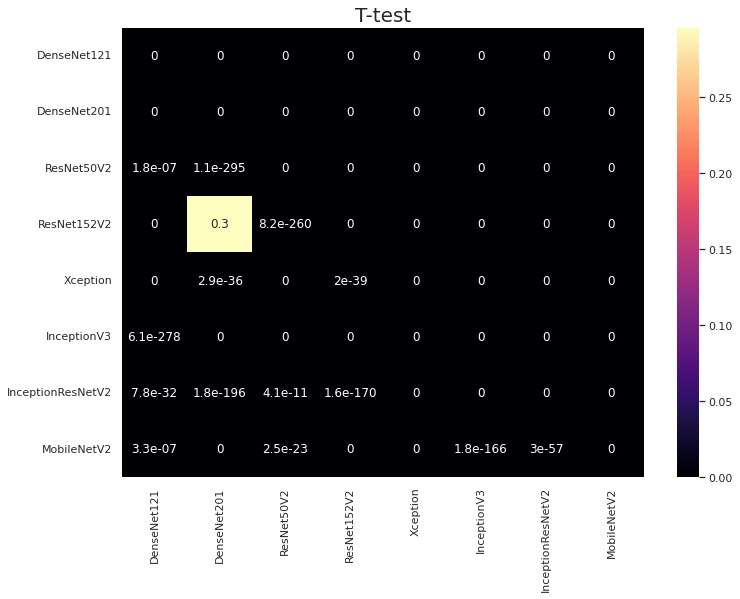

In [162]:
mat = [[0 for _ in range (len(archis))] for _ in range(len(archis))]

for i in range(len(archis)):
    for j in range(i+1, len(archis)):
        s, p = stats.ttest_ind(df[archis[j]], df[archis[i]], equal_var=False)
        mat[j][i] = p

sns.set(rc={'figure.figsize':(11.7,8.27)})

# plt.matshow(np.array(mat))
plt.title('T-test', fontsize = 20)
sns.heatmap(np.array(mat), annot=True, xticklabels=archis, yticklabels=archis, cmap='magma')

## Saliency Map

In [ ]:
def get_saliency_map(model, image):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = model(image)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)

    dgrad_abs = tf.math.abs(gradient)
#         print(dgrad_abs.shape)
    dgrad_max_ = np.max(dgrad_abs, axis=-1)[0]
#         print(dgrad_max_.shape)

    # normaliz between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    smap = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    return smap

In [ ]:
linear_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].output)
for i in order[-20:]:
    print(preds[i])
    smap = get_saliency_map(linear_model, tf.Variable(img[i], dtype=float))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i][0])

    plt.subplot(1, 2, 2)
    plt.imshow(smap, cmap='Reds')

    plt.show()

In [ ]:
smaps = []
for i in range(len(img)):
    smaps.append(get_saliency_map(linear_model, tf.Variable(img[i], dtype=float)))

In [ ]:
mean_img = np.mean(img, axis=0)
plt.subplot(1, 2, 1)
plt.imshow(mean_img[0], cmap='gray')

mean_smap = np.mean(smaps, axis=0)
plt.subplot(1, 2, 2)
plt.imshow(mean_smap, cmap='Reds')

plt.show()